## Process Fielddata

**Code authored by:** Andrew Johnson, Simon Zwieback, Franz Meyer, Jie Chen</br>
2024

This notebook takes the field observations and combines them into a single surface displacement for each field site, so that they can be properly compared to InSAR products.

NOTE: The field data will be added to the Cal/Val database. Before then, the 2023 data is provided by a set of small .csv files included here. 

### Prepare notebook environment

First we import functions, set directories, and the site metadata.

In [9]:

from pathlib import Path
import numpy as np
import pandas as pd
import os
from solid_utils import permafrost_utils as pu
from matplotlib import pyplot as plt
from datetime import datetime


In [16]:
site='NorthSlopeEastD102'
year=2025

base_dir = Path.cwd()
work_dir = base_dir/'work'/'permafrost_ouputs'/site/str(year)
field_dir = work_dir/'fielddata'

print("Field directory:", field_dir)
work_dir.mkdir(parents=True, exist_ok=True)
field_dir.mkdir(parents=True,exist_ok=True)

Field directory: /home/jovyan/forks/ATBD/methods/permafrost/work/permafrost_ouputs/NorthSlopeEastD102/2025/fielddata


In [17]:
fieldsites = ['HV','HVE','IC','SM']
fieldsitenames = ['Happy Valley','Happy Valley East','Ice Cut','Slope Mountain']
fieldsitelocs = [[69.15478,-148.84382],[69.15531,-148.83792],[69.04113,-148.83162],[68.43289,-148.94216]]

### Open Field Data

Each field site covers a 100 by 100 m square of the tundra. We use a fixed benchmark, usually a PVC pipe frozen into a several-meter deep borehole as a non-deforming point on the terrain. There are 3 transects, each of 100 m in length and spaced 50 m apart in order to cover the entire site. Ever 2 meters along the transect we marked a point by a nail in the ground. In the field we use GNSS and leveling (surveying) to measure the elevation of each of these points along the transects relative to the fixed benchmark. These measurements are made at the beginning and end of the summer when the surface is snow-free.

The first step is to open the field data from the .csv files.

In these files, the 'pointname' column has the format Txxyy: xx is the transact number, yy is the point number in each transact. yy *  2 will give you meters along transect, going from South to North and/or West to East (transects are not perfectly aligned South-North).

Data quality flags:</br>
0: High quality;</br>
1: Low quality with deviation to the averaged value larger than 15 cm;</br>
2: Unreasonable data;</br>
3: No data

In [11]:

def getRelElv(subsite: str, year:int, measMethod: str, dataInput:str = 'DB',removeflags=[2,3]):
    middate = datetime(year,7,15)
    pts = pu.pointnames(subsite)

    if dataInput == 'from_csv':
        data = pd.read_csv('fielddata/measured_displacement.csv')
        data['measurement_date'] = [datetime.strptime(i,'%Y-%m-%d') for i in data['measurement_date']]

    m1,m2 = [],[] #early/late summer measurement
    date1,date2 = np.nan,np.nan
    
    for pt in pts:
        ptdata = data.query(f'point_id_keystr == "{pt}" and measurement_type == "{measMethod}"')
        d1,d2 = pu.sortyeardate(ptdata,year,middate)
        meas1, meas2 = np.nan,np.nan
        if len(d1)>=1:
            meas1 = d1.iloc[0]['relative_elevation_m']
            date1 = pd.Timestamp(d1.iloc[0]['measurement_date']).to_pydatetime()
            mflag = d1.iloc[0]['measurement_flag']
            if mflag in removeflags:
                meas = np.nan
        m1.append(meas1)
        
        if len(d2)>=1:
            meas2 = d2.iloc[0]['relative_elevation_m']
            date2 = pd.Timestamp(d2.iloc[0]['measurement_date']).to_pydatetime()
            mflag = d2.iloc[0]['measurement_flag']
            if mflag in removeflags:
                meas2 = np.nan
        m2.append(meas2)
    
    return np.array(m1),np.array(m2),date1,date2,pts


Regarding 2023, the transects for the site Happy Valley East were created in August 2023, and therefore subsidence measurements do not exist for that summer. At Slope Mountain, the GNSS measurements were not collected in June 2023, and therefore summer displacements only come from the surveying.

Now we can plot the field measurements.

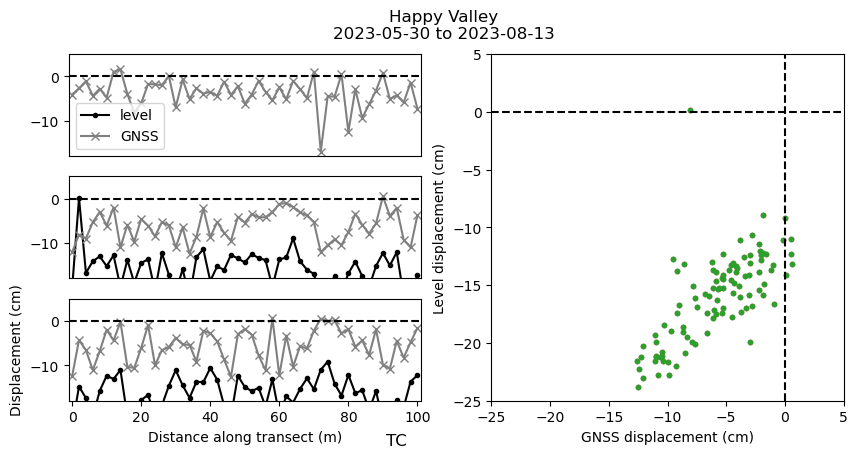

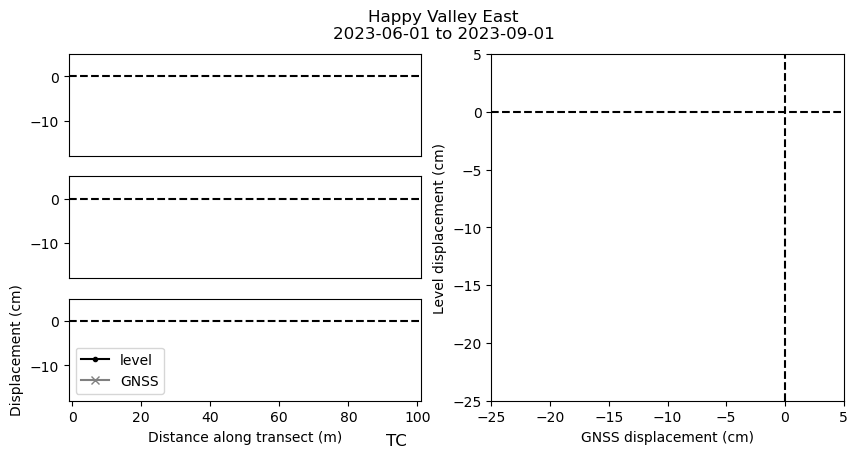

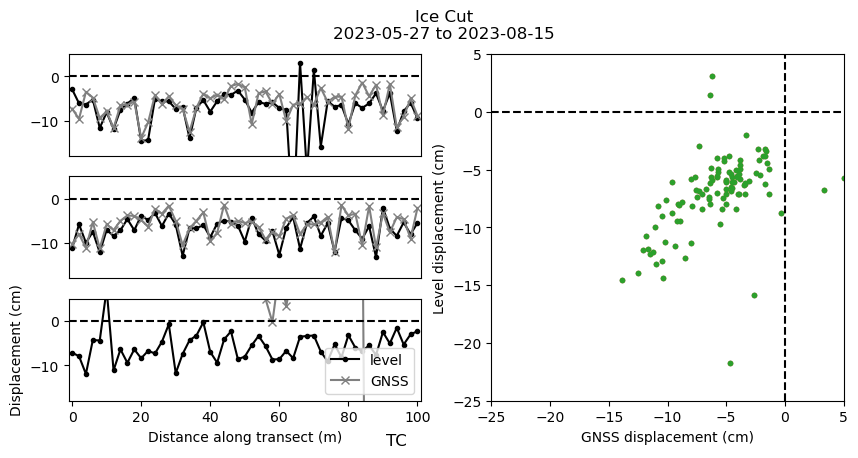

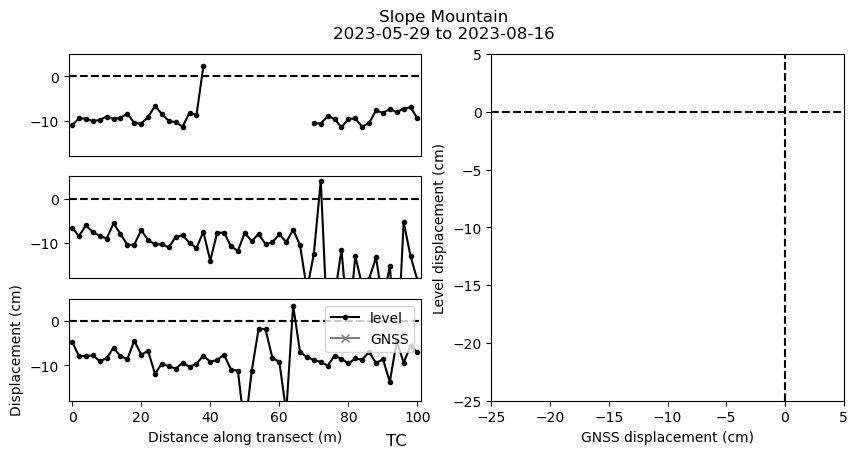

In [13]:
trdist = np.linspace(0,100,51)
tnames = ['TA','TB','TC']
for k,subsite in enumerate(fieldsites):
    lv1,lv2,lvd1,lvd2,pts = getRelElv(subsite,year,'level',dataInput = 'from_csv')
    gn1,gn2,gnd1,gnd2,__ = getRelElv(subsite,year,'gnss',dataInput = 'from_csv')
    lvd,gnd = lv2-lv1,gn2-gn1
    if pd.isnull(lvd1):
        lvd1 = datetime(year,6,1)
    if pd.isnull(lvd2):
        lvd2 = datetime(year,9,1)
    
    fig = plt.figure(figsize=(10,4.5))
    ax = fig.add_subplot(1,2,2)
    d1str = lvd1.strftime('%Y-%m-%d')
    d2str = lvd2.strftime('%Y-%m-%d')
    fig.suptitle(f'{fieldsitenames[k]}\n{d1str} to {d2str}')
    for i in range(3):
        axt = fig.add_subplot(3,2,1+i*2)   
        plt.plot(trdist,lvd[i*51:(i+1)*51]*100,'.-',color='black',label='level')
        plt.plot(trdist,gnd[i*51:(i+1)*51]*100,'x-',color='gray',label='GNSS')

        axt.set_ylim(-18,5)
        axt.set_xlim(-1,101)
        axt.axhline(0,linestyle='--',color='k')
        t=tnames[i]
        axt.text(91,-28,t,fontsize=12)
        
        if i<2:
            axt.set_xticks([])
        if i==2:
            if k!=0:
                axt.legend()
            axt.set_xlabel('Distance along transect (m)')
            axt.set_ylabel('Displacement (cm)')
        if k==0:
            if i==0:
                axt.legend(loc=3)

        ax.plot(gnd*100,lvd*100,'.')

    ax.axhline(0,linestyle='--',color='k')
    ax.axvline(0,linestyle='--',color='k')
    # ax.legend()
    ax.set_xlim([-25,5])
    ax.set_ylim([-25,5])
    ax.set_xlabel('GNSS displacement (cm)')
    ax.set_ylabel('Level displacement (cm)')


### Save mean values

We take the mean value across each 100 m site to make it comprable to the InSAR results. The mean values and standard deviations are saved into ```field_results.csv```.

In [14]:
# year = 2025
fielddisp = pd.DataFrame(columns = ['name','date1','date2','rel_change','stdev'])
for k,subsite in enumerate(fieldsites):
    lat,lon = fieldsitelocs[k]
    lv1,lv2,lvd1,lvd2,pts = getRelElv(subsite,year,'level',dataInput = 'from_csv')
    gn1,gn2,gnd1,gnd2,__ = getRelElv(subsite,year,'gnss',dataInput = 'from_csv')
    lvd,gnd = lv2-lv1,gn2-gn1
    if pd.isnull(lvd1):
        lvd1 = datetime(year,6,1)
    if pd.isnull(lvd2):
        lvd2 = datetime(year,9,1)

    ldisp,lstd = np.nanmean(lvd),np.nanstd(lvd)/np.sqrt(np.sum(~np.isnan(lvd)))
    gdisp,gstd = np.nanmean(gnd),np.nanstd(gnd)/np.sqrt(np.sum(~np.isnan(gnd)))
    tdisp = np.nanmean([ldisp,gdisp])

    #get standard deviation between measurement types, propogate errors
    #conditional used to avoid dividing by zero if there is no data
    stdvec = np.array([lstd,gstd])
    ntot = np.sum(~np.isnan(stdvec))
    if ntot>0:
        tstd = 1/ntot*np.sqrt(np.nansum(stdvec**2))
    else:
        tstd = np.nan

    print(f'{subsite}')
    print(f'Mean from leveling: {ldisp*100:.1f} +/- {lstd*100:.1f} cm')
    print(f'Mean from GNSS:     {gdisp*100:.1f} +/- {gstd*100:.1f} cm')
    print(f'Overall mean:       {tdisp*100:.1f} +/- {tstd*100:.1f} cm\n')

    
    sitedata = [subsite,lvd1,lvd2,tdisp,tstd]
    fielddisp.loc[k]=sitedata
print('Displaying dataframe:')
print(fielddisp)

svfile = field_dir/'field_results.csv'
print(f'\n Saving data to {str(svfile)}')
fielddisp.to_csv(svfile)

HV
Mean from leveling: -16.0 +/- 0.4 cm
Mean from GNSS:     -5.2 +/- 0.3 cm
Overall mean:       -10.6 +/- 0.2 cm



/tmp/ipykernel_2913/2746273392.py:13: RuntimeWarning: Mean of empty slice
  ldisp,lstd = np.nanmean(lvd),np.nanstd(lvd)/np.sqrt(np.sum(~np.isnan(lvd)))
/home/jovyan/.local/envs/solid_earth_atbd/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2913/2746273392.py:14: RuntimeWarning: Mean of empty slice
  gdisp,gstd = np.nanmean(gnd),np.nanstd(gnd)/np.sqrt(np.sum(~np.isnan(gnd)))
/tmp/ipykernel_2913/2746273392.py:15: RuntimeWarning: Mean of empty slice
  tdisp = np.nanmean([ldisp,gdisp])


HVE
Mean from leveling: nan +/- nan cm
Mean from GNSS:     nan +/- nan cm
Overall mean:       nan +/- nan cm

IC
Mean from leveling: -6.8 +/- 0.3 cm
Mean from GNSS:     -6.1 +/- 3.1 cm
Overall mean:       -6.5 +/- 1.5 cm

SM
Mean from leveling: -9.9 +/- 0.4 cm
Mean from GNSS:     nan +/- nan cm
Overall mean:       -9.9 +/- 0.4 cm

Displaying dataframe:
  name      date1      date2  rel_change     stdev
0   HV 2023-05-30 2023-08-13   -0.106156  0.002385
1  HVE 2023-06-01 2023-09-01         NaN       NaN
2   IC 2023-05-27 2023-08-15   -0.064948  0.015434
3   SM 2023-05-29 2023-08-16   -0.099498  0.004421

 Saving data to /home/jovyan/forks/ATBD/methods/permafrost/work/permafrost_ouputs/NorthSlopeEastD102/2023/fielddata/field_results.csv


/tmp/ipykernel_2913/2746273392.py:14: RuntimeWarning: Mean of empty slice
  gdisp,gstd = np.nanmean(gnd),np.nanstd(gnd)/np.sqrt(np.sum(~np.isnan(gnd)))
/home/jovyan/.local/envs/solid_earth_atbd/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
